In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Datmin/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aletbm/swiss-drone-and-okutama-drone-datasets
!mkdir swiss-drone-and-okutama-drone-datasets
!unzip swiss-drone-and-okutama-drone-datasets.zip -d /content/swiss-drone-and-okutama-drone-datasets

In [ ]:
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/ground_truth/train/* /content/swiss-drone-and-okutama-drone-datasets/ground_truth
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/ground_truth/test/* /content/swiss-drone-and-okutama-drone-datasets/ground_truth
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/ground_truth/val/* /content/swiss-drone-and-okutama-drone-datasets/ground_truth
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/images/train/* /content/swiss-drone-and-okutama-drone-datasets/images
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/images/test/* /content/swiss-drone-and-okutama-drone-datasets/images
!mv  -v /content/swiss-drone-and-okutama-drone-datasets/images/val/* /content/swiss-drone-and-okutama-drone-datasets/images

In [ ]:
!rm -r /content/swiss-drone-and-okutama-drone-datasets/ground_truth/test
!rm -r /content/swiss-drone-and-okutama-drone-datasets/ground_truth/train
!rm -r /content/swiss-drone-and-okutama-drone-datasets/ground_truth/val
!rm -r /content/swiss-drone-and-okutama-drone-datasets/images/test
!rm -r /content/swiss-drone-and-okutama-drone-datasets/images/train
!rm -r /content/swiss-drone-and-okutama-drone-datasets/images/val

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation, color, transform, measure, graph
from skimage.util import img_as_ubyte
from sklearn.metrics import jaccard_score
from skimage.metrics import structural_similarity as ssim
from skimage.measure import regionprops, regionprops_table
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import gaussian
from PIL import Image
import pandas as pd
import itertools
from collections import Counter

In [ ]:
# Fixed width while maintaining 16:9 ratio
FIXED_WIDTH = 960  # Adjust this as needed
FIXED_HEIGHT = int(FIXED_WIDTH * 9 / 16)  # Maintain 16:9 ratio
IMAGE_SIZE = (FIXED_HEIGHT, FIXED_WIDTH)
compactness=10
n_segments=100

# Define the color map
color_map = np.asarray([
    [0, 0, 0],         # Background
    [237, 237, 237],   # Outdoor structures
    [181, 0, 0],       # Buildings
    [135, 135, 135],   # Paved ground
    [189, 107, 0],     # Non-paved ground
    [128, 0, 128],     # Train tracks
    [31, 123, 22],     # Plants
    [6, 0, 130],       # Wheeled vehicles
    [0, 168, 255],     # Water
    [240, 255, 0],     # People
])



In [ ]:
def gt_color_manual(label_img):
    # Ensure label_img is 2D (single channel)
    if len(label_img.shape) > 2:
        label_img = label_img[:, :, 0]  # Take first channel if multi-channel

    # Create a colored image from the labels
    rgb_img = np.zeros((label_img.shape[0], label_img.shape[1], 3), dtype=np.uint8)

    for i in range(len(color_map)):
        rgb_img[label_img == i] = color_map[i]

    return rgb_img

In [ ]:
def compute_mask(image):
  color_dict = {}

  # Get the shape of the image
  height,width,_ = image.shape

  # Create an empty array for labels
  labels = np.zeros((height,width),dtype=int)
  id=0
  # Loop over each pixel
  for i in range(height):
      for j in range(width):
          # Get the color of the pixel
          color = tuple(image[i,j])
          # Check if it is in the dictionary
          if color in color_dict:
              # Assign the label from the dictionary
              labels[i,j] = color_dict[color]
          else:
              color_dict[color]=id
              labels[i,j] = id
              id+=1

  return(labels)

In [ ]:
# Function to recolor the image based on majority color from ground truth
def recolor_image_based_on_majority_color(image, ground_truth, label, regionprop_table):
    recolored_image = np.copy(image)

    for region_props in regionprop_table:
        region_id = region_props['region_id']
        mask = label == region_id

        # Count pixel occurrences within the masked region
        pixels_tuple = [tuple(ground_truth[i, j]) for i in range(ground_truth.shape[0]) for j in range(ground_truth.shape[1]) if mask[i, j]]
        color_counts = Counter(pixels_tuple)

        # Get the most common color
        majority_color = color_counts.most_common(1)[0][0]
        recolored_image[mask] = majority_color

    return recolored_image

In [ ]:
def create_region_table(rag, label):
  props = regionprops(label)
  regionprop_table = []
  for prop in props:
      region_id = prop.label  # Region ID (label)

      # If the region exists in the RAG
      if region_id in rag.nodes:
          # Get region properties from regionprops
          region_area = prop.area
          region_centroid = prop.centroid
          region_bbox = prop.bbox

          # Get RAG properties (e.g., mean color)
          rag_mean_color = rag.nodes[region_id]['mean color']

          # Store all properties in a dictionary (this can be a row in the table)
          regionprop_table.append({
              'region_id': region_id,
              'area': region_area,
              'centroid': region_centroid,
              'bounding_box': region_bbox,
              'mean_color': rag_mean_color
          })
  return regionprop_table

In [ ]:
# Load the image and its ground truth
image = io.imread('/content/swiss-drone-and-okutama-drone-datasets/images/okutama_02_50_016.png')
ground_truth = io.imread('/content/swiss-drone-and-okutama-drone-datasets/ground_truth/okutama_02_50_016.png')
gt_rgb = gt_color_manual(ground_truth);

# show images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(ground_truth)
ax[1].set_title('Ground Truth')
ax[2].imshow(gt_rgb)
ax[2].set_title('Ground Truth (RGB)')
plt.show()

Text(0.5, 1.0, 'Segmented image (normalized cut)')

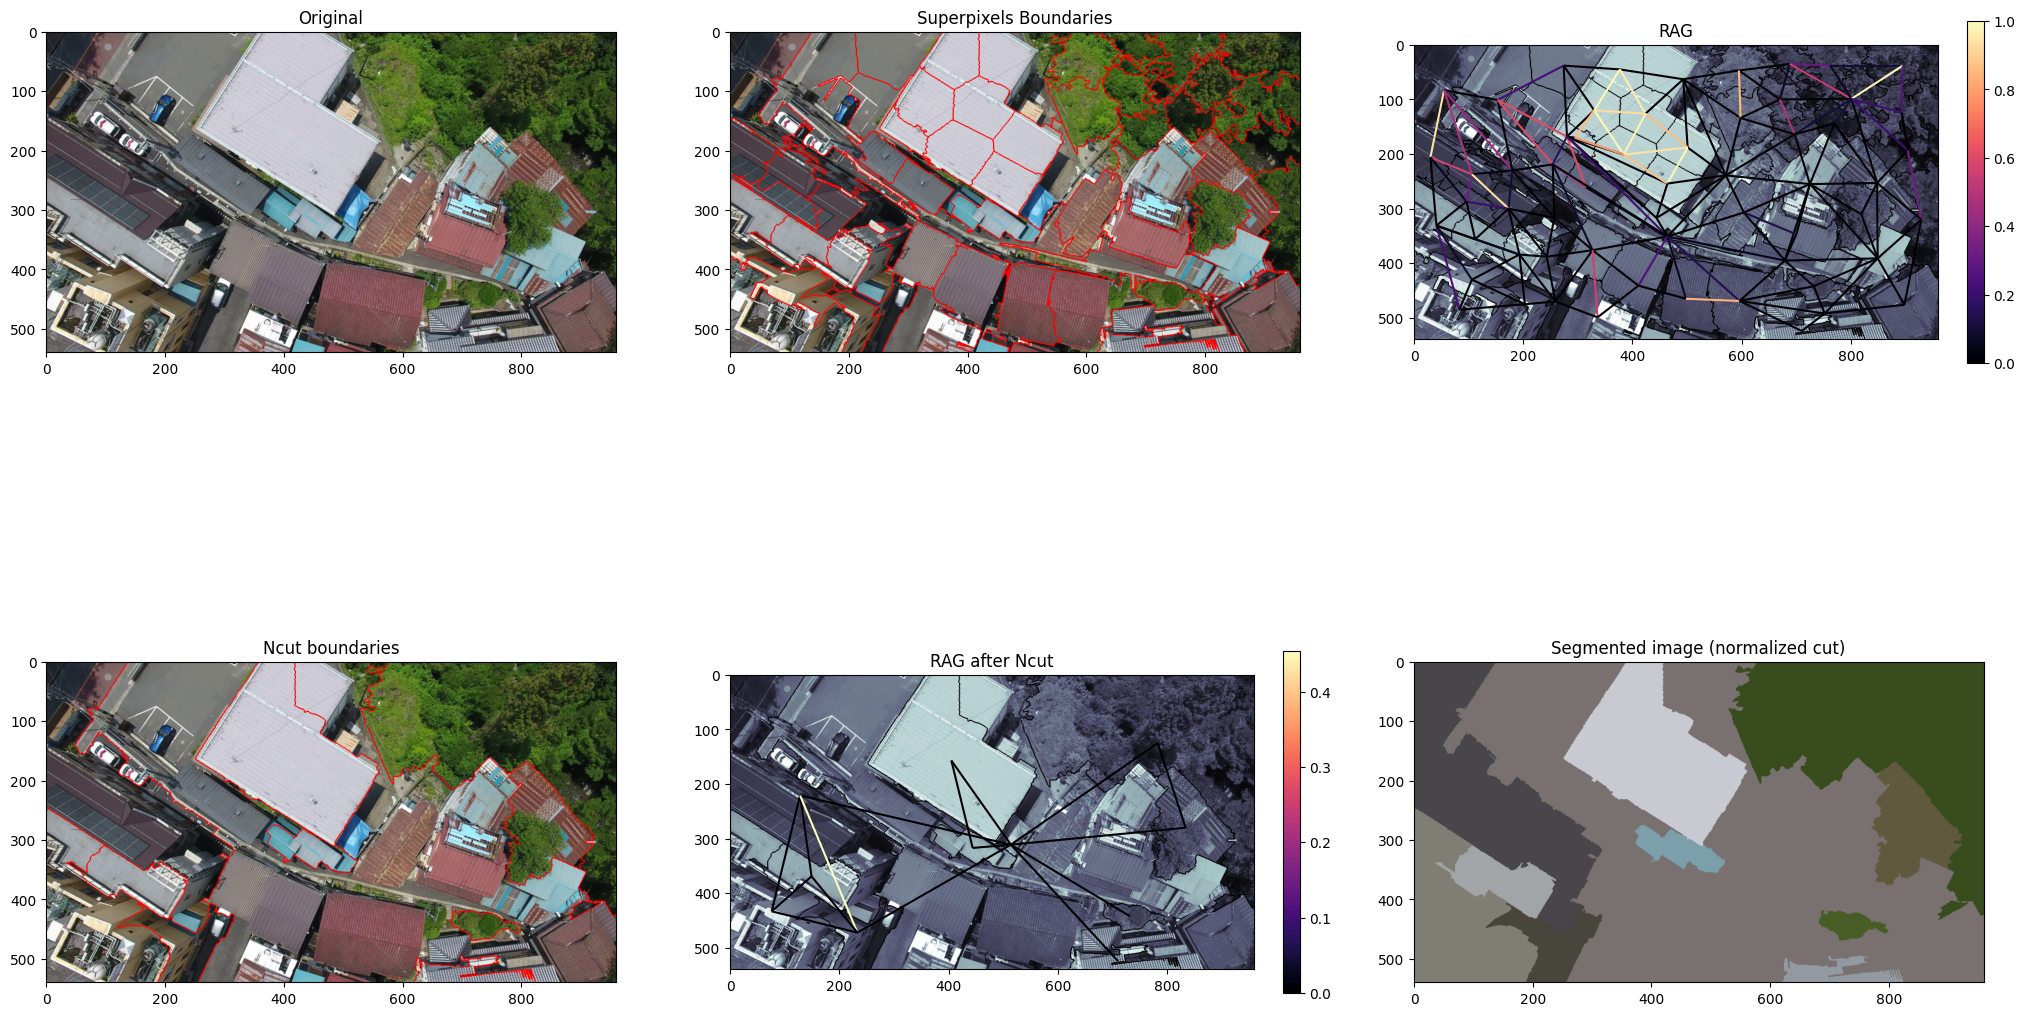

In [ ]:
# Resize while maintaining 16:9 ratio
image = img_as_ubyte(transform.resize(image, IMAGE_SIZE, anti_aliasing=True))
ground_truth = img_as_ubyte(transform.resize(ground_truth, IMAGE_SIZE, anti_aliasing=True))
gt_rgb = img_as_ubyte(transform.resize(gt_rgb, IMAGE_SIZE, anti_aliasing=True))
image_gaussian = gaussian(image, sigma=1, channel_axis=2)

labels = segmentation.slic(image_gaussian, compactness=compactness, n_segments=n_segments, enforce_connectivity=True, channel_axis=2)
image_with_boundaries = img_as_ubyte(segmentation.mark_boundaries(image, labels, color=(1, 0, 0)))

# using the labels found with the superpixeled image
# compute the Region Adjacency Graph using mean colors
g = graph.rag_mean_color(image, labels, mode='similarity')

# perform Normalized Graph cut on the Region Adjacency Graph
labels2 = graph.cut_normalized(labels, g)
relab, forward_map, inverse_map = segmentation.relabel_sequential(labels2)
image_with_boundaries_ncut = img_as_ubyte(segmentation.mark_boundaries(image, relab, color=(1, 0, 0)))
segmented_image = color.label2rgb(relab, image, kind='avg')

fig, ax = plt.subplots(2, 3, figsize=(25, 15))

ax[0, 0].imshow(image)
ax[0, 0].set_title("Original")

#plot boundaries
ax[0, 1].imshow(image_with_boundaries)
ax[0, 1].set_title("Superpixels Boundaries")

# RAG
ax[0, 2].set_title('RAG')
lc = graph.show_rag(labels, g, image_with_boundaries, ax=ax[0, 2])
fig.colorbar(lc, fraction=0.03, ax=ax[0, 2])


# Ncut boundaries
ax[1, 0].set_title('Ncut boundaries')
ax[1, 0].imshow(image_with_boundaries_ncut)

# RAG Ncut
g2 = graph.rag_mean_color(image, relab, mode='similarity')  # Recalculate RAG using labels2
ax[1, 1].set_title('RAG after Ncut')
nc = graph.show_rag(relab, g2, image_with_boundaries_ncut, ax=ax[1, 1])
fig.colorbar(nc, fraction=0.03, ax=ax[1, 1])

#compute segmentation
ax[1, 2].imshow(segmented_image)
ax[1, 2].set_title('Segmented image (normalized cut)')

In [ ]:
regionprops_table = create_region_table(g2, relab)
recolored_image = recolor_image_based_on_majority_color(image, gt_rgb, relab, regionprops_table)
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Show the original image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Show the recolored image
ax[1].imshow(gt_rgb)
ax[1].set_title("ground truth")
ax[1].axis('off')

# Show the recolored image
ax[2].imshow(recolored_image)
ax[2].set_title("Recolored Label")
ax[2].axis('off')

ssim_score = ssim(recolored_image, gt_rgb, channel_axis=2)
jac = jaccard_score(y_true=gt_rgb.flatten(),
                    y_pred=recolored_image.flatten(),
                    average='micro')


print(f"IoU: {jac:.4f}")
print(f"SSIM: {ssim_score:.4f}")

In [ ]:
# Load the image and its ground truth
image_folder = "/content/swiss-drone-and-okutama-drone-datasets/images/"
gt_folder = "/content/swiss-drone-and-okutama-drone-datasets/ground_truth/"

image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.png')]



Only one label found for 50, 100, 960 x 540, skipping...
Average Mean IoU: 0.5299
Average SSIM: 0.6901
eigenvalue not found for 50, 200, 960 x 540, skipping...
eigenvalue not found for 50, 200, 960 x 540, skipping...
Only one label found for 50, 200, 960 x 540, skipping...
Average Mean IoU: 0.5554
Average SSIM: 0.7025
Average Mean IoU: 0.5476
Average SSIM: 0.6957
Only one label found for 50, 400, 960 x 540, skipping...
Average Mean IoU: 0.5672
Average SSIM: 0.7078
Only one label found for 50, 500, 960 x 540, skipping...
Only one label found for 50, 500, 960 x 540, skipping...
Average Mean IoU: 0.5615
Average SSIM: 0.7048


Compactness  Num Clusters  Mean SSIM  Mean IoU
0           50           100   0.690117  0.529908
1           50           200   0.702462  0.555387
2           50           300   0.695664  0.547578
3           50           400   0.707790  0.567229
4           50           500   0.704752  0.561472

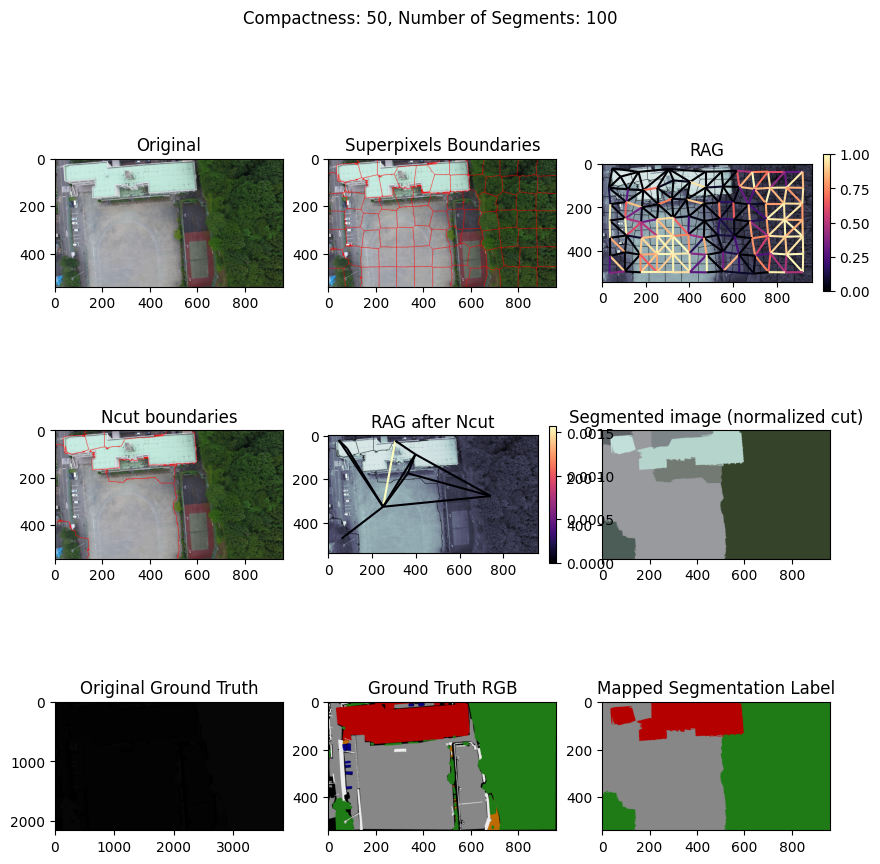

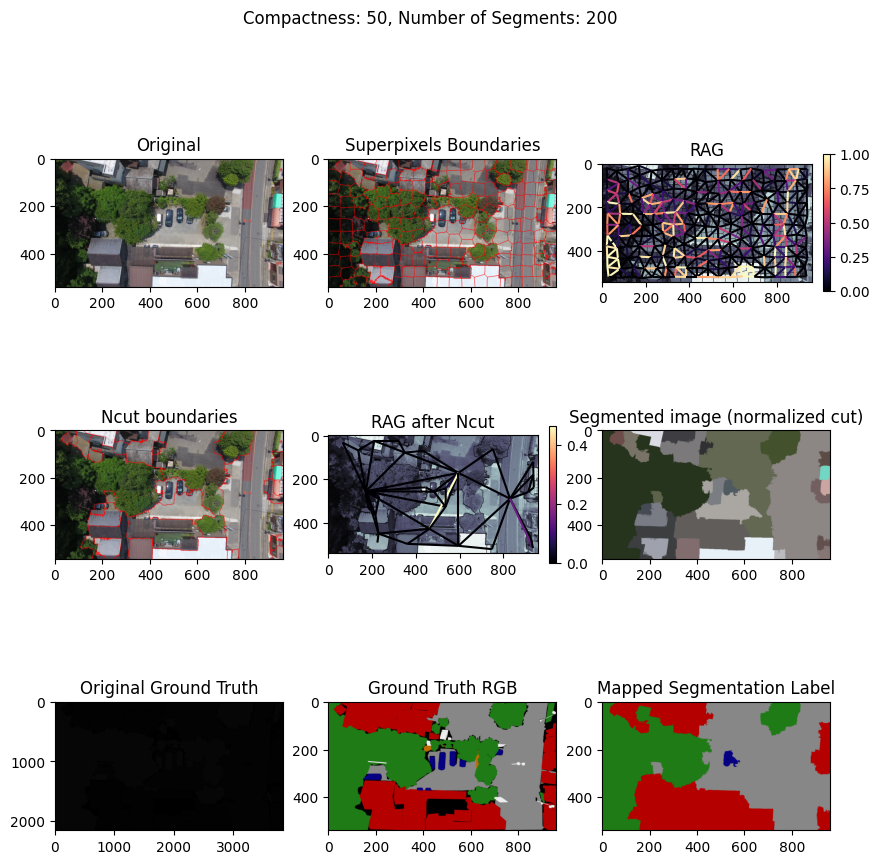

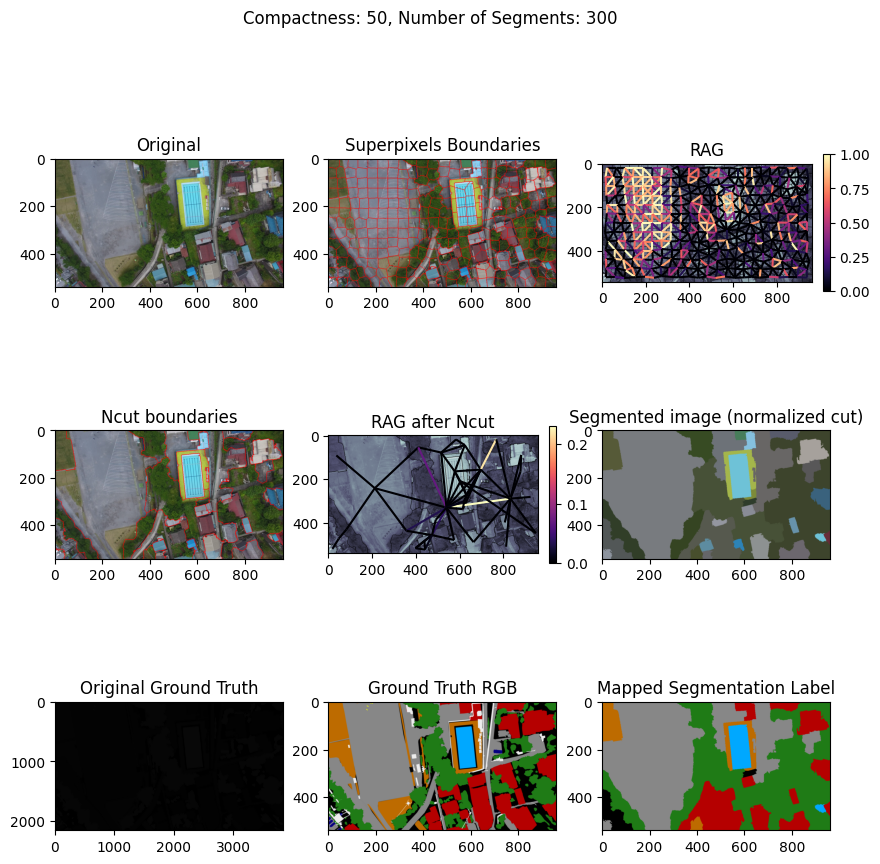

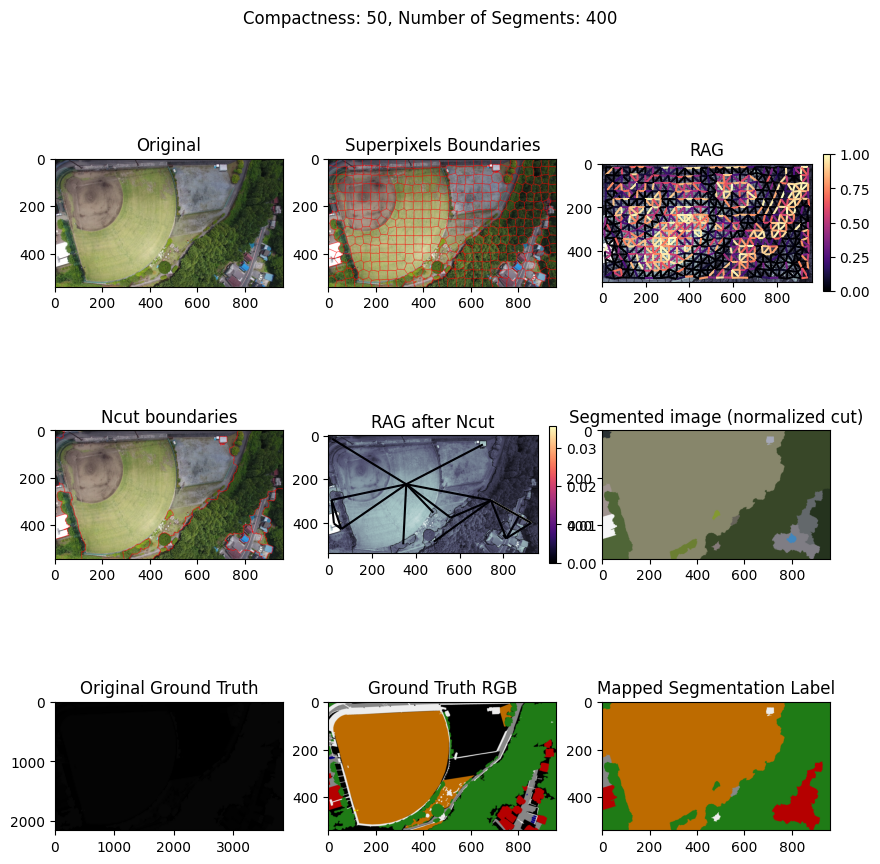

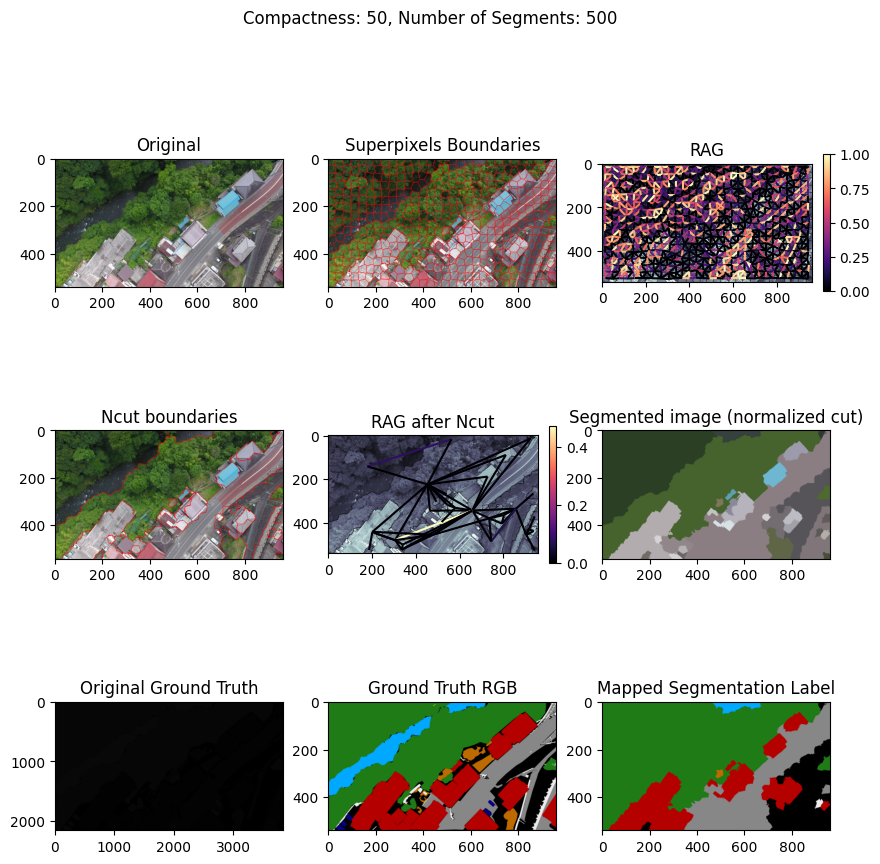

In [ ]:
compactness_sizes = [50]  # Compactness values
cluster_nums = [100, 200, 300, 400, 500]  # Number of segments

# Results storage
results = []

for comp in compactness_sizes:
  for clusters in cluster_nums:
    # Select a random image for visualization
    random_image = random.choice(image_filenames)
    # Store evaluation metrics
    iou_scores = []
    ssim_scores = []
    for filename in image_filenames:
      # Load image and ground truth
      image_path = os.path.join(image_folder, filename)
      gt_path = os.path.join(gt_folder, filename)

      image = io.imread(image_path)
      ground_truth_original = io.imread(gt_path)
      ground_truth = gt_color_manual(ground_truth_original);

      # Resize while maintaining 16:9 ratio
      image = img_as_ubyte(transform.resize(image, IMAGE_SIZE, anti_aliasing=True))
      ground_truth = img_as_ubyte(transform.resize(ground_truth, IMAGE_SIZE, anti_aliasing=True))
      #image_gaussian = gaussian(image, sigma=1, channel_axis=2)

      # Perform superpixel segmentation
      labels = segmentation.slic(image, compactness=comp, n_segments=clusters, enforce_connectivity=True)
      image_with_boundaries = img_as_ubyte(segmentation.mark_boundaries(image, labels, color=(1, 0, 0)))

      # Compute Region Adjacency Graph (RAG)
      g = graph.rag_mean_color(image, labels, mode='similarity')

      # Apply normalized cut segmentation
      try:
        labels2 = graph.cut_normalized(labels, g)
        if len(np.unique(labels2)) == 1:
          print(f"Only one label found for {comp}, {clusters}, {FIXED_WIDTH} x {FIXED_HEIGHT}, skipping...")
          continue
      except:
        print(f"eigenvalue not found for {comp}, {clusters}, {FIXED_WIDTH} x {FIXED_HEIGHT}, skipping...")
        continue
      segment_relab, forward_map, inverse_map = segmentation.relabel_sequential(labels2)
      image_with_boundaries_ncut = img_as_ubyte(segmentation.mark_boundaries(image, segment_relab, color=(1, 0, 0)))
      segmented_image = color.label2rgb(segment_relab, image, kind='avg')

      # Recalculate RAG using segment_relab
      g2 = graph.rag_mean_color(image, segment_relab, mode='similarity')

      # create color mapping
      regionprops_table = create_region_table(g2, segment_relab)
      recolored_image = recolor_image_based_on_majority_color(image, ground_truth, segment_relab, regionprops_table)

      # Compute Metrics
      ssim_score = ssim(recolored_image, ground_truth, channel_axis=2)

      jac = jaccard_score(y_true=ground_truth.flatten(),
                          y_pred=recolored_image.flatten(),
                          average='micro')
      iou_scores.append(jac)
      ssim_scores.append(ssim_score)

      # Show only one random image for visualization
      if filename == random_image:
        fig, ax = plt.subplots(3, 3, figsize=(10, 10))
        fig.suptitle(f"Compactness: {comp}, Number of Segments: {clusters}")

        ax[0, 0].imshow(image)
        ax[0, 0].set_title("Original")

        #plot boundaries
        ax[0, 1].imshow(image_with_boundaries)
        ax[0, 1].set_title("Superpixels Boundaries")

        # RAG
        ax[0, 2].set_title('RAG')
        lc = graph.show_rag(labels, g, image_with_boundaries, ax=ax[0, 2])
        fig.colorbar(lc, fraction=0.03, ax=ax[0, 2])

        # Ncut boundaries
        ax[1, 0].set_title('Ncut boundaries')
        ax[1, 0].imshow(image_with_boundaries_ncut)

        # RAG Ncut
        ax[1, 1].set_title('RAG after Ncut')
        nc = graph.show_rag(segment_relab, g2, image_with_boundaries_ncut, ax=ax[1, 1])
        fig.colorbar(nc, fraction=0.03, ax=ax[1, 1])

        #compute segmentation
        ax[1, 2].imshow(segmented_image)
        ax[1, 2].set_title('Segmented image (normalized cut)')

        ax[2, 0].imshow(ground_truth_original)
        ax[2, 0].set_title("Original Ground Truth")

        ax[2, 1].imshow(ground_truth)
        ax[2, 1].set_title("Ground Truth RGB")

        ax[2, 2].imshow(recolored_image)
        ax[2, 2].set_title("Mapped Segmentation Label")

    mean_iou = np.mean(iou_scores)
    mean_ssim = np.mean(ssim_scores)
    # Print final scores
    print(f"Average Mean IoU: {mean_iou:.4f}")
    print(f"Average SSIM: {mean_ssim:.4f}")

    # Store results
    results.append({
        'Compactness': comp,
        'Num Clusters': clusters,
        'Mean SSIM': mean_ssim,
        'Mean IoU': mean_iou
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Optionally, you can save this DataFrame to a CSV for further analysis:
results_df.to_csv(f"segmentation_evaluation_results_{FIXED_WIDTH}.csv", index=False)

# Display results
results_df